# DGD Training Demo: Using the DGDTrainer Class

This notebook demonstrates the complete usage of the DGDTrainer class from `src/training/trainer.py`. We'll train a Deep Generative Decoder (DGD) model on the FashionMNIST dataset, showcasing:

- Configuration setup using Hydra/OmegaConf
- Dataset preparation and data loading
- ClearML integration for experiment tracking
- Model training with representation layers and GMM fitting
- Visualization of training progress and results
- Model evaluation and sample generation
- Model saving and loading

The DGD model combines:
- **Representation Layer**: Learnable per-sample embeddings in latent space
- **Convolutional Decoder**: Neural network that maps latent codes to images
- **Gaussian Mixture Model**: Probabilistic model fitted to the learned representations

## 1. Setup Environment and Imports

First, let's import all necessary libraries and set up the environment.

In [16]:
# Standard library imports
import os
import sys
import time
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Data science and ML libraries
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import torchvision
import torchvision.transforms as transforms

# Configuration management
from omegaconf import DictConfig, OmegaConf
import hydra
from hydra import initialize, compose

# Experiment tracking
from clearml import Task

# Add project root to path for imports
current_dir = Path.cwd()
if 'notebooks' in current_dir.parts:
    # We're in the notebooks folder, go up one level
    project_root = current_dir.parent
else:
    project_root = current_dir

sys.path.append(str(project_root))
sys.path.append(str(project_root / 'src'))

# Import our custom modules
from src.training.trainer import DGDTrainer
from src.data.dataloader import create_dataloaders  # Fixed: was create_dataloader
from src.models import RepresentationLayer, DGD, ConvDecoder, GaussianMixture
from src.visualization import plot_training_losses, plot_images

# Set device and apply memory optimizations
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Apply CUDA memory optimizations for local training
if torch.cuda.is_available():
    # Clear GPU cache
    torch.cuda.empty_cache()
    
    # Set memory management optimizations
    os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True'
    
    # Enable memory-efficient attention if available
    try:
        torch.backends.cuda.enable_flash_sdp(False)  # Disable for compatibility
    except:
        pass
    
    print(f"✓ GPU: {torch.cuda.get_device_name()}")
    print(f"✓ GPU Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    print(f"✓ Applied CUDA memory optimizations")

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)

print("✓ All imports successful!")
print(f"✓ Project root: {project_root}")
print(f"✓ PyTorch version: {torch.__version__}")
print(f"✓ CUDA available: {torch.cuda.is_available()}")
print("✓ Memory optimizations applied for local training")

Using device: cuda
✓ GPU: NVIDIA GeForce RTX 4060 Laptop GPU
✓ GPU Memory: 8.2 GB
✓ Applied CUDA memory optimizations
✓ All imports successful!
✓ Project root: /home/asp/Downloads/HeaDS/ImageDGD
✓ PyTorch version: 2.4.0
✓ CUDA available: True
✓ Memory optimizations applied for local training


## 2. Load Configuration

Load the training configuration using Hydra/OmegaConf. We'll use the default configuration and show how to modify it for different experiments.

In [17]:
# Load configuration from the config directory
config_dir = project_root / "config"
print(f"Loading configuration from: {config_dir}")

# For Hydra initialize, we need to provide a relative path from the current working directory
# Since we're in the notebooks folder, the config folder is ../config
relative_config_path = "../config"

# Initialize Hydra with the relative config directory
with initialize(version_base=None, config_path=relative_config_path):
    # Use the minimal config for local training with limited GPU memory
    config = compose(config_name="config_minimal")

print("✓ Configuration loaded successfully!")
print(f"✓ Experiment: {config.experiment_name}")
print(f"✓ Dataset: {config.data.dataset}")
print(f"✓ Training epochs: {config.training.epochs}")
print(f"✓ Batch size: {config.data.batch_size}")
print(f"✓ Latent dimensions: {config.model.representation.n_features}")

# Further reduce settings for local GPU memory constraints
print("\n🔧 Applying additional memory optimizations for local training...")

# Reduce batch size further for limited GPU memory
config.data.batch_size = 128  # Reduced from 512
config.data.subset_fraction = 0.05  # Use only 5% of data
config.training.epochs = 10  # Even fewer epochs

# Simplify decoder architecture even more
config.model.decoder.hidden_dims = [32, 16]  # Smaller network
config.model.representation.n_features = 4   # Even smaller latent space

# Reduce GMM complexity
config.model.gmm.n_components = 2  # Just 2 components

# Disable figure saving to save memory
config.training.logging.save_figures = False
config.training.logging.plot_interval = 5

print("✓ Applied memory optimizations:")
print(f"  - Batch size: {config.data.batch_size}")
print(f"  - Data subset: {config.data.subset_fraction:.1%}")
print(f"  - Epochs: {config.training.epochs}")
print(f"  - Latent dims: {config.model.representation.n_features}")
print(f"  - Decoder dims: {list(config.model.decoder.hidden_dims)}")
print(f"  - GMM components: {config.model.gmm.n_components}")

# Display key configuration sections
print("\n🔧 Model Configuration:")
print(f"  Representation: {config.model.representation.distribution} distribution")
print(f"  Latent dims: {config.model.representation.n_features}")
print(f"  Decoder hidden dims: {list(config.model.decoder.hidden_dims)}")
print(f"  GMM components: {config.model.gmm.n_components}")

print("\n🎯 Training Configuration:")
print(f"  Decoder optimizer: {config.training.optimizer.decoder.type}")
print(f"  Representation optimizer: {config.training.optimizer.representation.type}")
print(f"  Learning rates: decoder={config.training.optimizer.decoder.lr}, rep={config.training.optimizer.representation.lr}")
print(f"  GMM starts at epoch: {config.training.first_epoch_gmm}")
print(f"  Lambda GMM: {config.training.lambda_gmm}")

print("\n💾 Memory Optimizations Applied:")
print("  ✓ Using minimal config")
print("  ✓ Small batch size (128)")
print("  ✓ Tiny data subset (5%)")
print("  ✓ Minimal model architecture")
print("  ✓ Disabled figure saving")
print("  ✓ Reduced training epochs")

Loading configuration from: /home/asp/Downloads/HeaDS/ImageDGD/config
✓ Configuration loaded successfully!
✓ Experiment: ImageDGD_Minimal_Test
✓ Dataset: FashionMNIST
✓ Training epochs: 20
✓ Batch size: 512
✓ Latent dimensions: 8

🔧 Applying additional memory optimizations for local training...
✓ Applied memory optimizations:
  - Batch size: 128
  - Data subset: 5.0%
  - Epochs: 10
  - Latent dims: 4
  - Decoder dims: [32, 16]
  - GMM components: 2

🔧 Model Configuration:
  Representation: uniform distribution
  Latent dims: 4
  Decoder hidden dims: [32, 16]
  GMM components: 2

🎯 Training Configuration:
  Decoder optimizer: Adam
  Representation optimizer: Adam
  Learning rates: decoder=0.01, rep=0.1
  GMM starts at epoch: 5
  Lambda GMM: 0.1

💾 Memory Optimizations Applied:
  ✓ Using minimal config
  ✓ Small batch size (128)
  ✓ Tiny data subset (5%)
  ✓ Minimal model architecture
  ✓ Disabled figure saving
  ✓ Reduced training epochs


## 3. Prepare Dataset and Data Loaders

Load and prepare the FashionMNIST dataset with proper transformations and create data loaders.

Data directory: /home/asp/Downloads/HeaDS/ImageDGD/data
✓ Configuration updated for FashionMNIST dataset
Loading dataset and creating data loaders...
Using small dataset, adjusted batch size: 128
Train dataset: 3000 (subset of total: 60000)
Test dataset: 500 (subset of total: 10000)
Image shape: torch.Size([1, 28, 28])
Image size: 784
✓ Train loader: 24 batches
✓ Test loader: 4 batches
✓ Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
✓ Prepared sample data for visualization
✓ Prepared sample data for visualization


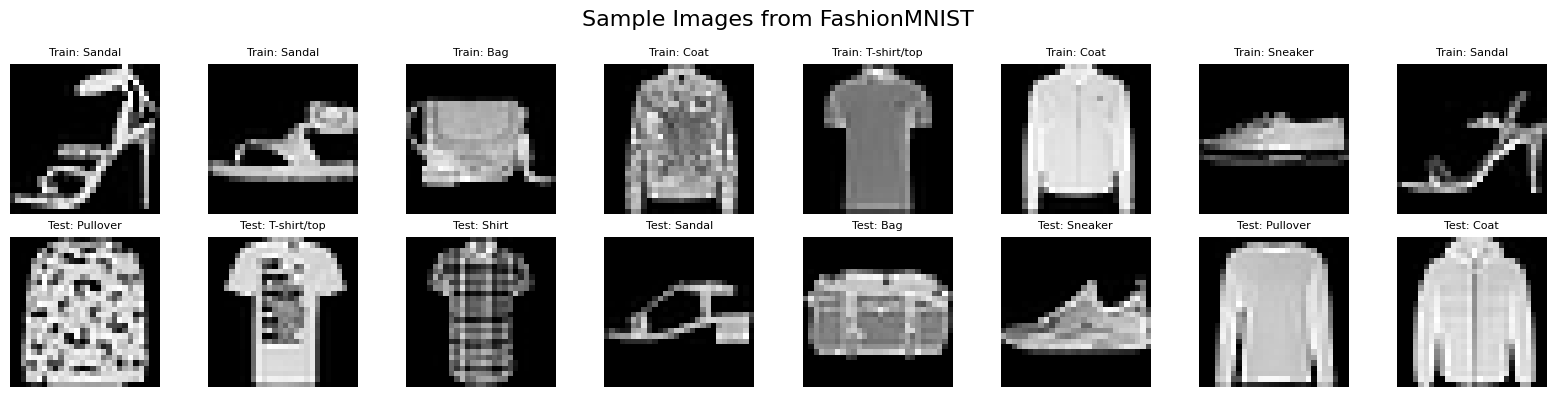

\n📊 Dataset Summary:
  Input shape: torch.Size([1, 28, 28])
  Number of classes: 10
  Classes: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
  Sample data shapes: train=16, test=16


In [18]:
# Create data directories
data_dir = project_root / "data"
data_dir.mkdir(exist_ok=True)

print(f"Data directory: {data_dir}")

# OmegaConf is in struct mode, so we need to disable it to add new fields
# Or we can use existing fields and work with the dataloader function expectations
OmegaConf.set_struct(config, False)  # Disable struct mode temporarily

# Update the config to work with the dataloader function
# The dataloader expects specific field names that may not be in the config
config.data.root_dir = str(data_dir)  # Add root_dir for dataloader
config.data.data_dir = str(data_dir)  # Update existing data_dir
config.data.dataset_name = "FashionMNIST"  # Add dataset_name for dataloader
config.data.download = True

# Add transform configuration that the dataloader expects
config.data.transforms = OmegaConf.create({
    "train": ["ToTensor", "Normalize"],
    "test": ["ToTensor", "Normalize"]
})

# Add missing fields with defaults
config.data.shuffle_train = True
config.data.shuffle_test = False

# Define class names for FashionMNIST
class_names = [
    'T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
    'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot'
]

# Also update the class names in config
config.data.class_names = class_names

# Re-enable struct mode if desired
OmegaConf.set_struct(config, True)

print("✓ Configuration updated for FashionMNIST dataset")

# Create data loaders using our custom dataloader function
print("Loading dataset and creating data loaders...")
train_loader, test_loader, loaded_class_names = create_dataloaders(config)

print(f"✓ Train loader: {len(train_loader)} batches")
print(f"✓ Test loader: {len(test_loader)} batches")
print(f"✓ Classes: {loaded_class_names}")

# Prepare sample data for visualization
def prepare_sample_data(train_loader, test_loader, n_samples=16):
    """Prepare sample data for visualization during training."""
    # Get sample indices and images from train set
    train_batch = next(iter(train_loader))
    indices_train, images_train, labels_train = train_batch
    
    # Take first n_samples
    indices_train = indices_train[:n_samples]
    images_train = images_train[:n_samples]
    labels_train = labels_train[:n_samples]
    
    # Get sample indices and images from test set  
    test_batch = next(iter(test_loader))
    indices_test, images_test, labels_test = test_batch
    
    # Take first n_samples
    indices_test = indices_test[:n_samples]
    images_test = images_test[:n_samples] 
    labels_test = labels_test[:n_samples]
    
    return (indices_train, images_train, labels_train, 
            indices_test, images_test, labels_test)

sample_data = prepare_sample_data(train_loader, test_loader)
print(f"✓ Prepared sample data for visualization")

# Visualize some samples
fig, axes = plt.subplots(2, 8, figsize=(16, 4))
fig.suptitle('Sample Images from FashionMNIST', fontsize=16)

for i in range(8):
    # Train samples
    img = sample_data[1][i].squeeze()
    label = sample_data[2][i].item()
    axes[0, i].imshow(img, cmap='gray')
    axes[0, i].set_title(f'Train: {class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Test samples  
    img = sample_data[4][i].squeeze()
    label = sample_data[5][i].item()
    axes[1, i].imshow(img, cmap='gray')
    axes[1, i].set_title(f'Test: {class_names[label]}', fontsize=8)
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()

print("\\n📊 Dataset Summary:")
print(f"  Input shape: {sample_data[1][0].shape}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Classes: {class_names}")
print(f"  Sample data shapes: train={len(sample_data[1])}, test={len(sample_data[4])}")

## 4. Initialize ClearML Task

Set up ClearML for experiment tracking. This will log all training metrics, configurations, and artifacts.

In [19]:
# Initialize ClearML task for experiment tracking
print("Initializing ClearML task...")

try:
    # Create a task for this training session
    task = Task.init(
        project_name="ImageDGD", 
        task_name=f"DGD Training Demo - {config.model.representation.distribution}",
        tags=["demo", "notebook", config.data.dataset, f"{config.training.epochs}epochs"]
    )
    
    # Connect the configuration to ClearML
    task.connect(config)
    
    # Set task description
    task.set_comment("""
    DGD Training Demo using DGDTrainer class.
    
    This experiment demonstrates:
    - Deep Generative Decoder training
    - Representation layer learning
    - GMM fitting in latent space
    - Training visualization and monitoring
    """)
    
    print("✓ ClearML task initialized successfully!")
    print(f"✓ Project: ImageDGD")
    print(f"✓ Task: DGD Training Demo - {config.model.representation.distribution}")
    print(f"✓ Task ID: {task.id}")
    
    # Get dataset sizes from the data loaders
    train_dataset_size = len(train_loader.dataset)
    test_dataset_size = len(test_loader.dataset)
    
    # Log some initial parameters
    task.set_parameters({
        "dataset_size_train": train_dataset_size,
        "dataset_size_test": test_dataset_size,
        "device": str(device),
        "pytorch_version": torch.__version__,
        "subset_used": config.data.use_subset,
        "subset_fraction": config.data.subset_fraction if config.data.use_subset else None
    })
    
except Exception as e:
    print(f"⚠️ ClearML initialization failed: {e}")
    print("⚠️ Continuing without ClearML tracking...")
    task = None

print("\\n📝 Experiment Configuration:")
print(f"  Project: ImageDGD")
print(f"  Task: DGD Training Demo")
print(f"  Dataset: {config.data.dataset}")
print(f"  Model: DGD (Deep Generative Decoder)")  # Fixed: removed non-existent config.model.type
print(f"  Distribution: {config.model.representation.distribution}")
print(f"  Device: {device}")
print(f"  Tracking: {'ClearML' if task else 'Local only'}")

Initializing ClearML task...
✓ ClearML task initialized successfully!
✓ Project: ImageDGD
✓ Task: DGD Training Demo - uniform
✓ Task ID: 5cb88899252a4a09974432d8bda03ee7
✓ ClearML task initialized successfully!
✓ Project: ImageDGD
✓ Task: DGD Training Demo - uniform
✓ Task ID: 5cb88899252a4a09974432d8bda03ee7
\n📝 Experiment Configuration:
  Project: ImageDGD
  Task: DGD Training Demo
  Dataset: FashionMNIST
  Model: DGD (Deep Generative Decoder)
  Distribution: uniform
  Device: cuda
  Tracking: ClearML
\n📝 Experiment Configuration:
  Project: ImageDGD
  Task: DGD Training Demo
  Dataset: FashionMNIST
  Model: DGD (Deep Generative Decoder)
  Distribution: uniform
  Device: cuda
  Tracking: ClearML


## 5. Create and Configure Trainer

Now let's instantiate the DGDTrainer with our configuration and device settings.

In [20]:
# Create the DGDTrainer instance
print("Creating DGDTrainer...")

trainer = DGDTrainer(
    config=config,
    device=device,
    verbose=True  # Enable detailed logging
)

print("✓ DGDTrainer created successfully!")

# The trainer will automatically handle:
# - Model component creation (decoder, representation layers, GMM)
# - Optimizer setup based on configuration
# - Loss computation and tracking
# - Visualization generation
# - ClearML logging integration

print("\\n🔧 Trainer Configuration:")
print(f"  Device: {trainer.device}")
print(f"  Verbose mode: {trainer.verbose}")
print(f"  Training config: {trainer.training_config.epochs} epochs")
print(f"  GMM starts at epoch: {trainer.training_config.first_epoch_gmm}")
print(f"  Lambda GMM: {trainer.training_config.lambda_gmm}")
print(f"  Log interval: {trainer.training_config.logging.log_interval}")
print(f"  Plot interval: {trainer.training_config.logging.plot_interval}")
print(f"  Save figures: {trainer.training_config.logging.save_figures}")

print("\\n📊 Optimizer Configuration:")
print(f"  Decoder optimizer: {config.training.optimizer.decoder.type}")
print(f"    - Learning rate: {config.training.optimizer.decoder.lr}")
print(f"    - Weight decay: {config.training.optimizer.decoder.weight_decay}")
print(f"  Representation optimizer: {config.training.optimizer.representation.type}")
print(f"    - Learning rate: {config.training.optimizer.representation.lr}")
print(f"    - Weight decay: {config.training.optimizer.representation.weight_decay}")

print("\\n🏗️ Model Architecture:")
print(f"  Representation dimension: {config.model.representation.n_features}")
print(f"  Distribution type: {config.model.representation.distribution}")
print(f"  Decoder hidden dims: {list(config.model.decoder.hidden_dims)}")
print(f"  Decoder activation: {config.model.decoder.activation}")
print(f"  Decoder final activation: {config.model.decoder.final_activation}")
print(f"  GMM components: {config.model.gmm.n_components}")
print(f"  GMM covariance type: {config.model.gmm.covariance_type}")

print("\\n✅ Trainer is ready for training!")

Creating DGDTrainer...
✓ DGDTrainer created successfully!
\n🔧 Trainer Configuration:
  Device: cuda
  Verbose mode: True
  Training config: 10 epochs
  GMM starts at epoch: 5
  Lambda GMM: 0.1
  Log interval: 5
  Plot interval: 5
  Save figures: False
\n📊 Optimizer Configuration:
  Decoder optimizer: Adam
    - Learning rate: 0.01
    - Weight decay: 0.0
  Representation optimizer: Adam
    - Learning rate: 0.1
    - Weight decay: 0.0
\n🏗️ Model Architecture:
  Representation dimension: 4
  Distribution type: uniform
  Decoder hidden dims: [32, 16]
  Decoder activation: relu
  Decoder final activation: sigmoid
  GMM components: 2
  GMM covariance type: diag
\n✅ Trainer is ready for training!


## 6. Run Training Process

Now let's start the training! The trainer will handle everything including model creation, optimization, GMM fitting, and visualization.

In [21]:
# Start training!
print("🚀 Starting DGD training...")
print("=" * 60)

# Record start time
training_start_time = time.time()

# Run the training process
# The trainer.train() method handles:
# - Model component creation (decoder, representation layers, GMM)
# - Optimizer setup and configuration
# - Training loop with progress tracking
# - GMM fitting at specified intervals
# - Loss computation and logging
# - Visualization generation and saving
# - ClearML metric logging

try:
    results = trainer.train(
        train_loader=train_loader,
        test_loader=test_loader,
        sample_data=sample_data,
        class_names=class_names
    )
    
    training_end_time = time.time()
    total_training_time = training_end_time - training_start_time
    
    print("\\n" + "=" * 60)
    print("🎉 Training completed successfully!")
    print(f"⏱️ Total training time: {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")
    
    # Extract results
    model = results['model']
    rep_layer = results['rep']
    test_rep_layer = results['test_rep']
    gmm = results['gmm']
    train_losses = results['train_losses']
    test_losses = results['test_losses']
    
    print(f"\\n📊 Final Results:")
    print(f"  Final train loss: {results['final_train_loss']:.6f}")
    print(f"  Final test loss: {results['final_test_loss']:.6f}")
    print(f"  Best train loss: {min(train_losses):.6f} (epoch {train_losses.index(min(train_losses)) + 1})")
    print(f"  Best test loss: {min(test_losses):.6f} (epoch {test_losses.index(min(test_losses)) + 1})")
    
    # Model information
    decoder_params = sum(p.numel() for p in model.decoder.parameters() if p.requires_grad)
    rep_params = sum(p.numel() for p in rep_layer.parameters() if p.requires_grad)
    test_rep_params = sum(p.numel() for p in test_rep_layer.parameters() if p.requires_grad)
    total_params = decoder_params + rep_params + test_rep_params
    
    print(f"\\n🏗️ Model Statistics:")
    print(f"  Decoder parameters: {decoder_params:,} ({decoder_params/1e6:.2f}M)")
    print(f"  Train representation parameters: {rep_params:,} ({rep_params/1e6:.2f}M)")
    print(f"  Test representation parameters: {test_rep_params:,} ({test_rep_params/1e6:.2f}M)")
    print(f"  Total parameters: {total_params:,} ({total_params/1e6:.2f}M)")
    
    print(f"\\n🎯 GMM Information:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Number of iterations: {gmm.n_iter_}")
    
except Exception as e:
    print(f"❌ Training failed with error: {e}")
    import traceback
    traceback.print_exc()
    raise e

print("\\n✅ Training phase completed!")

🚀 Starting DGD training...
Decoder parameters: 17,305 (0.02M)
Train representation parameters: 12,000 (0.01M)
Test representation parameters: 2,000 (0.00M)
Total trainable parameters: 31,305 (0.03M)
Training for 10 epochs
Using device: cuda
Batch size: 128
Using data subset: 5.0%


Training:  40%|████      | 4/10 [00:03<00:05,  1.20it/s]

Fitting GMM at epoch 5...


Training:  50%|█████     | 5/10 [00:04<00:04,  1.04it/s]

Epoch 5/10 [TPE: 0:00:01, RT: 0:00:04]; Train Loss: 535.7447 (-0.09%), Test Loss: 535.7084 (-0.10%)
  Reconstruction - Train: 535.2839, Test: 535.1745
  GMM Loss - Train: 0.4609, Test: 0.5339


Training:  90%|█████████ | 9/10 [00:07<00:00,  1.14it/s]

Fitting GMM at epoch 10...


Training: 100%|██████████| 10/10 [00:09<00:00,  1.10it/s]

Epoch 10/10 [TPE: 0:00:01, RT: 0:00:00]; Train Loss: 535.7940 (0.00%), Test Loss: 535.4658 (0.01%)
  Reconstruction - Train: 535.2839, Test: 535.1745
  GMM Loss - Train: 0.5101, Test: 0.2913
Training completed in 0:00:09
Final training loss: 535.7940
Final test loss: 535.4658
\n============================================================
🎉 Training completed successfully!
⏱️ Total training time: 10.85 seconds (0.18 minutes)
\n📊 Final Results:
  Final train loss: 535.794007
  Final test loss: 535.465797
  Best train loss: 535.283877 (epoch 4)
  Best test loss: 535.174531 (epoch 2)
\n🏗️ Model Statistics:
  Decoder parameters: 17,305 (0.02M)
  Train representation parameters: 12,000 (0.01M)
  Test representation parameters: 2,000 (0.00M)
  Total parameters: 31,305 (0.03M)
\n🎯 GMM Information:
  Number of components: 2
  Covariance type: diag
  Converged: True
  Number of iterations: 1
\n✅ Training phase completed!


## 7. Analyze Training Results

Let's analyze the training results by examining loss curves, reconstruction quality, and model performance.

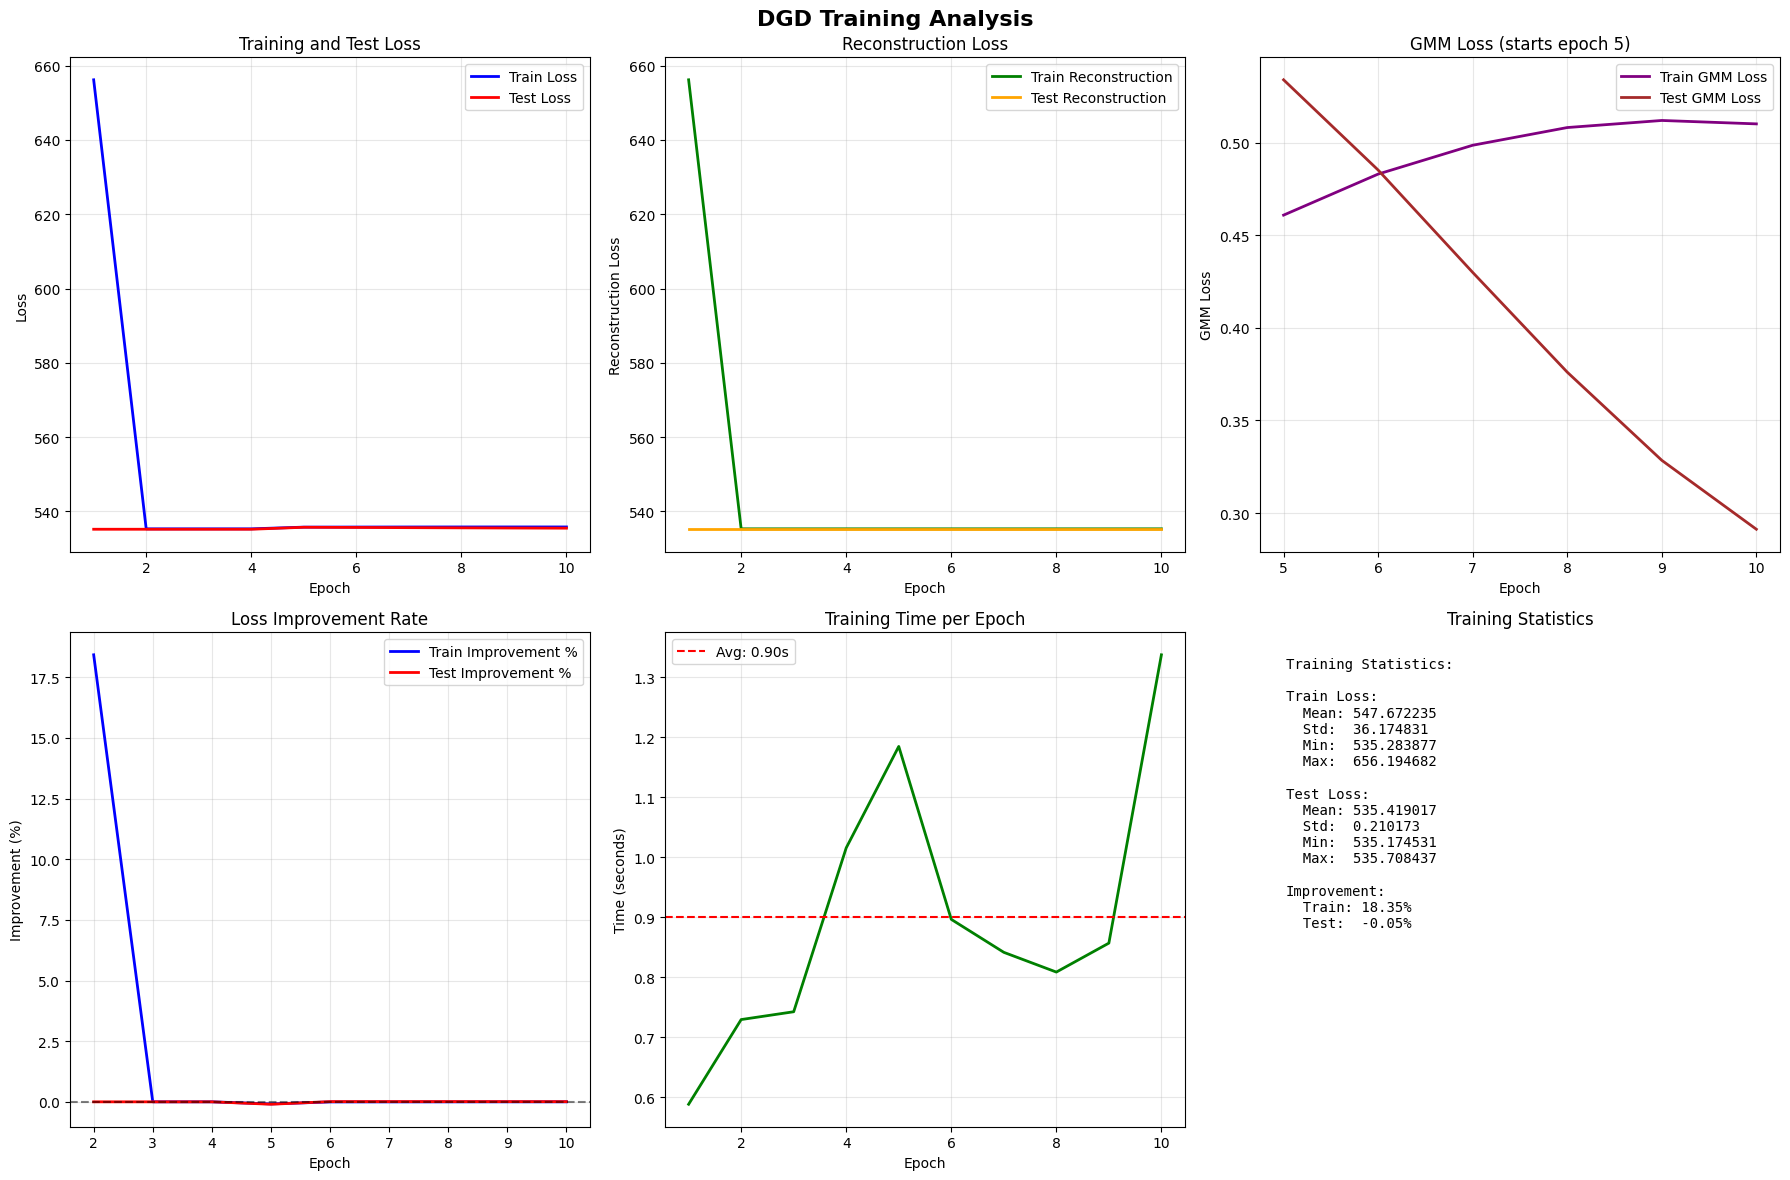

📊 Training Analysis Complete!
✓ Total epochs: 10
✓ Training improvement: 18.35%
✓ Test improvement: -0.05%
✓ Average epoch time: 0.90 seconds
✓ GMM fitted: Yes


In [22]:
# Plot comprehensive training analysis
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('DGD Training Analysis', fontsize=16, fontweight='bold')

# 1. Training and Test Loss
axes[0, 0].plot(range(1, len(train_losses) + 1), train_losses, 'b-', label='Train Loss', linewidth=2)
axes[0, 0].plot(range(1, len(test_losses) + 1), test_losses, 'r-', label='Test Loss', linewidth=2)
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].set_title('Training and Test Loss')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Reconstruction Losses
recon_train_losses = trainer.recon_train_losses
recon_test_losses = trainer.recon_test_losses
axes[0, 1].plot(range(1, len(recon_train_losses) + 1), recon_train_losses, 'g-', label='Train Reconstruction', linewidth=2)
axes[0, 1].plot(range(1, len(recon_test_losses) + 1), recon_test_losses, 'orange', label='Test Reconstruction', linewidth=2)
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Reconstruction Loss')
axes[0, 1].set_title('Reconstruction Loss')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 3. GMM Losses (after GMM starts)
gmm_train_losses = trainer.gmm_train_losses
gmm_test_losses = trainer.gmm_test_losses
gmm_start_epoch = config.training.first_epoch_gmm

if len(gmm_train_losses) > 0 and any(x != 0 for x in gmm_train_losses):
    non_zero_epochs = [i+1 for i, x in enumerate(gmm_train_losses) if x != 0]
    non_zero_train = [x for x in gmm_train_losses if x != 0]
    non_zero_test = [gmm_test_losses[i] for i, x in enumerate(gmm_train_losses) if x != 0]
    
    axes[0, 2].plot(non_zero_epochs, non_zero_train, 'purple', label='Train GMM Loss', linewidth=2)
    axes[0, 2].plot(non_zero_epochs, non_zero_test, 'brown', label='Test GMM Loss', linewidth=2)
    axes[0, 2].set_xlabel('Epoch')
    axes[0, 2].set_ylabel('GMM Loss')
    axes[0, 2].set_title(f'GMM Loss (starts epoch {gmm_start_epoch})')
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)
else:
    axes[0, 2].text(0.5, 0.5, 'GMM not fitted yet\\nor no GMM loss', ha='center', va='center', transform=axes[0, 2].transAxes)
    axes[0, 2].set_title('GMM Loss')

# 4. Loss Improvement Rate
if len(train_losses) > 1:
    train_improvements = [((train_losses[i-1] - train_losses[i]) / train_losses[i-1] * 100) if train_losses[i-1] != 0 else 0 
                         for i in range(1, len(train_losses))]
    test_improvements = [((test_losses[i-1] - test_losses[i]) / test_losses[i-1] * 100) if test_losses[i-1] != 0 else 0 
                        for i in range(1, len(test_losses))]
    
    axes[1, 0].plot(range(2, len(train_losses) + 1), train_improvements, 'b-', label='Train Improvement %', linewidth=2)
    axes[1, 0].plot(range(2, len(test_losses) + 1), test_improvements, 'r-', label='Test Improvement %', linewidth=2)
    axes[1, 0].axhline(y=0, color='black', linestyle='--', alpha=0.5)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Improvement (%)')
    axes[1, 0].set_title('Loss Improvement Rate')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 5. Epoch Times
epoch_times = trainer.epoch_times
if len(epoch_times) > 0:
    axes[1, 1].plot(range(1, len(epoch_times) + 1), epoch_times, 'green', linewidth=2)
    axes[1, 1].axhline(y=np.mean(epoch_times), color='red', linestyle='--', label=f'Avg: {np.mean(epoch_times):.2f}s')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Time (seconds)')
    axes[1, 1].set_title('Training Time per Epoch')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

# 6. Loss Summary Statistics
train_mean = np.mean(train_losses)
train_std = np.std(train_losses)
test_mean = np.mean(test_losses)
test_std = np.std(test_losses)

stats_text = f"""Training Statistics:

Train Loss:
  Mean: {train_mean:.6f}
  Std:  {train_std:.6f}
  Min:  {min(train_losses):.6f}
  Max:  {max(train_losses):.6f}

Test Loss:
  Mean: {test_mean:.6f}
  Std:  {test_std:.6f}
  Min:  {min(test_losses):.6f}
  Max:  {max(test_losses):.6f}

Improvement:
  Train: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%
  Test:  {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%
"""

axes[1, 2].text(0.05, 0.95, stats_text, transform=axes[1, 2].transAxes, fontsize=10, 
                verticalalignment='top', fontfamily='monospace')
axes[1, 2].set_title('Training Statistics')
axes[1, 2].axis('off')

plt.tight_layout()
plt.show()

print("📊 Training Analysis Complete!")
print(f"✓ Total epochs: {len(train_losses)}")
print(f"✓ Training improvement: {((train_losses[0] - train_losses[-1]) / train_losses[0] * 100):.2f}%")
print(f"✓ Test improvement: {((test_losses[0] - test_losses[-1]) / test_losses[0] * 100):.2f}%")
print(f"✓ Average epoch time: {np.mean(epoch_times):.2f} seconds")
print(f"✓ GMM fitted: {'Yes' if gmm.converged_ else 'No'}")

## 8. Model Evaluation and Testing

Let's evaluate the trained model by examining reconstruction quality and computing various metrics.

🔍 Evaluating trained DGD model...
✓ Reconstruction MSE - Train: 0.713560 ± 0.126025
✓ Reconstruction MSE - Test: 0.646539 ± 0.120926


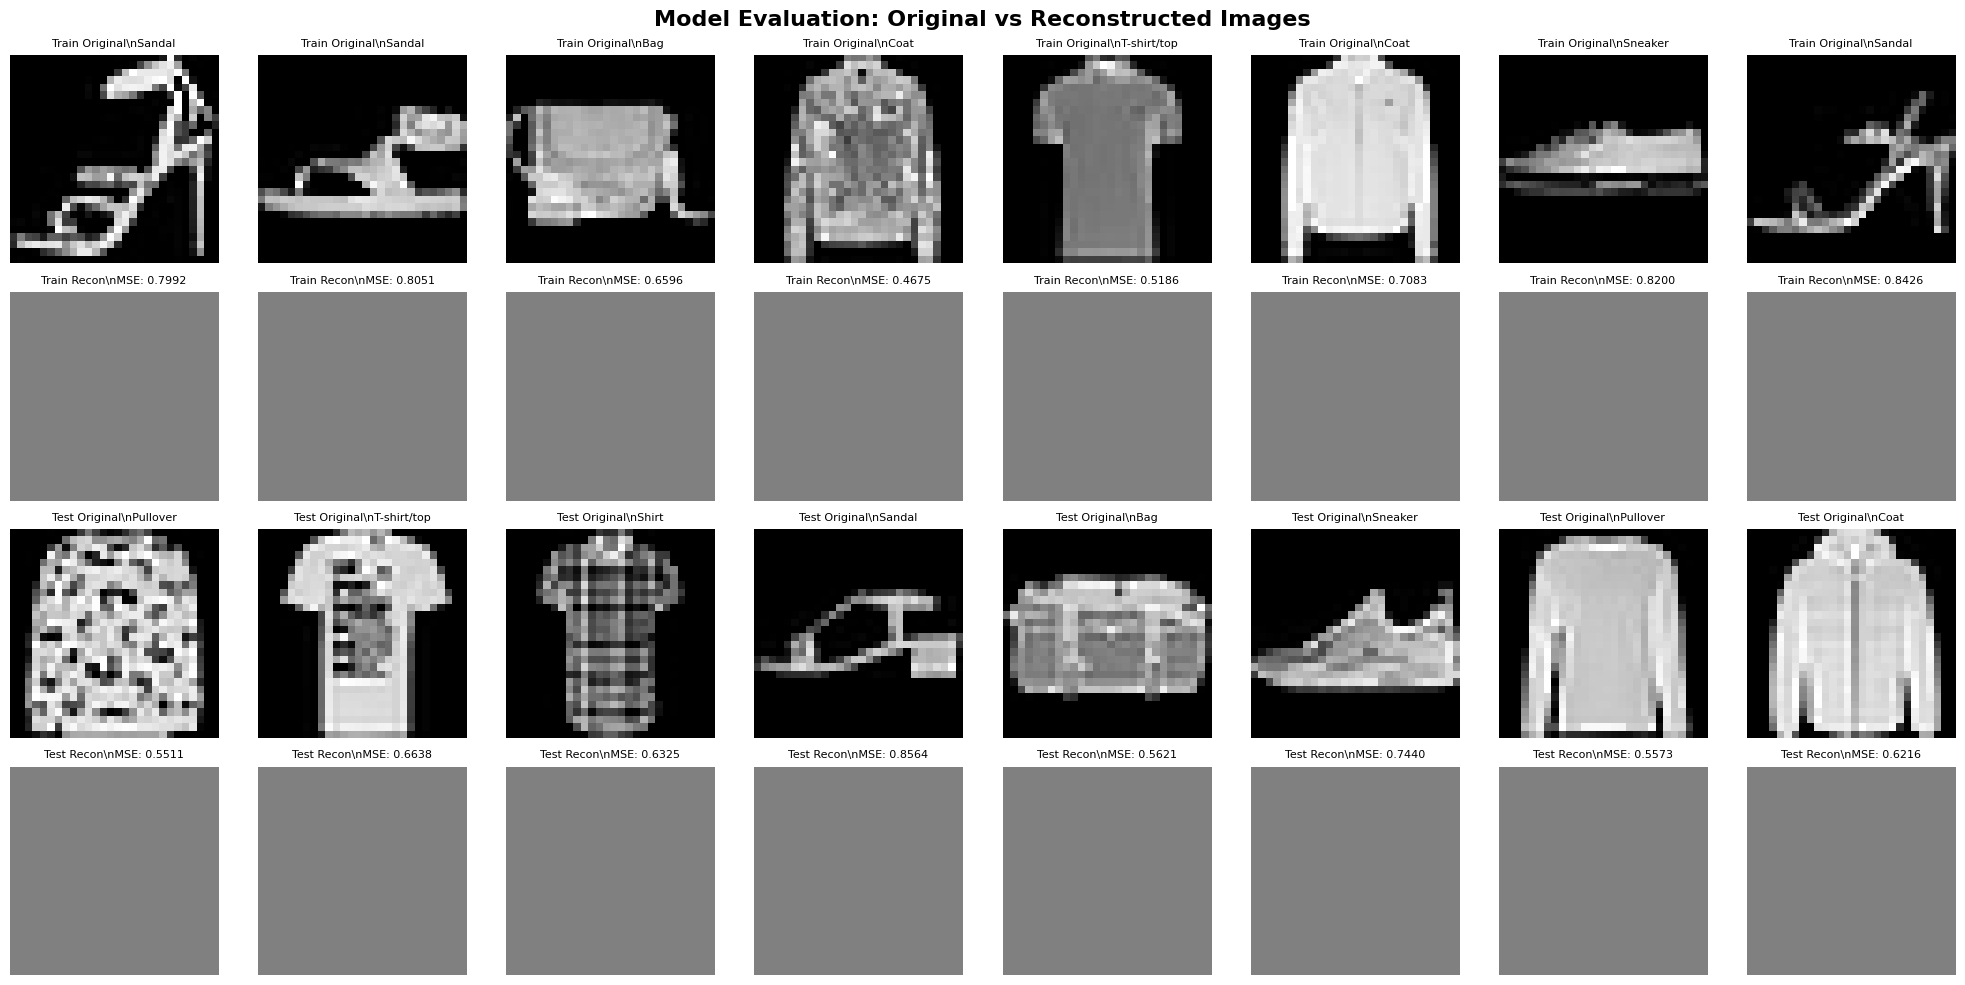

\n📊 Comprehensive Model Evaluation:
\n🎯 Reconstruction Quality:
  Train samples: 3000
  Test samples: 500
  Sample train MSE: 0.713560 ± 0.126025
  Sample test MSE: 0.646539 ± 0.120926
\n🌌 Latent Space Analysis:
  Latent dimension: 4
  Train latent norm: 1.6331 ± 0.0000
  Test latent norm: 0.8224 ± 0.0482
  Latent range: [-1.021, 0.848]
\n🎲 GMM Evaluation:
  Number of components: 2
  Covariance type: diag
  Converged: True
  Iterations: 1
  Train log-likelihood: -5.1854 ± 0.0000
  Test log-likelihood: -2.5575 ± 0.1626
  Component weights: tensor([0.7209, 0.2791], device='cuda:0')
  Effective components: 2 / 2
\n✅ Model evaluation completed!


In [23]:
# Evaluate the trained model
print("🔍 Evaluating trained DGD model...")

# Set model to evaluation mode
model.eval()

# Test reconstruction quality on sample data
with torch.no_grad():
    # Get sample data
    indices_train, images_train, labels_train, indices_test, images_test, labels_test = sample_data
    
    # Move to device
    indices_train = indices_train.to(device)
    images_train = images_train.to(device)
    indices_test = indices_test.to(device)
    images_test = images_test.to(device)
    
    # Generate reconstructions
    z_train = rep_layer(indices_train)
    recon_train = model.decoder(z_train)
    
    z_test = test_rep_layer(indices_test)
    recon_test = model.decoder(z_test)
    
    # Compute reconstruction errors
    train_mse = F.mse_loss(recon_train, images_train, reduction='none').mean(dim=[1,2,3])
    test_mse = F.mse_loss(recon_test, images_test, reduction='none').mean(dim=[1,2,3])
    
    print(f"✓ Reconstruction MSE - Train: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
    print(f"✓ Reconstruction MSE - Test: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# Visualize reconstructions
fig, axes = plt.subplots(4, 8, figsize=(20, 10))
fig.suptitle('Model Evaluation: Original vs Reconstructed Images', fontsize=16, fontweight='bold')

# Convert tensors to CPU and numpy for plotting
images_train_cpu = images_train.cpu()
recon_train_cpu = recon_train.cpu()
images_test_cpu = images_test.cpu()
recon_test_cpu = recon_test.cpu()
labels_train_cpu = labels_train.cpu()
labels_test_cpu = labels_test.cpu()

for i in range(8):
    # Original train images
    img = images_train_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_train_cpu[i].item()
    axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[0, i].set_title(f'Train Original\\n{class_names[label]}', fontsize=8)
    axes[0, i].axis('off')
    
    # Reconstructed train images
    img = recon_train_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = train_mse[i].item()
    axes[1, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[1, i].set_title(f'Train Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[1, i].axis('off')
    
    # Original test images
    img = images_test_cpu[i].squeeze()
    img = (img + 1) / 2  # Denormalize from [-1,1] to [0,1]
    label = labels_test_cpu[i].item()
    axes[2, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[2, i].set_title(f'Test Original\\n{class_names[label]}', fontsize=8)
    axes[2, i].axis('off')
    
    # Reconstructed test images
    img = recon_test_cpu[i].squeeze()
    img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
    mse = test_mse[i].item()
    axes[3, i].imshow(img, cmap='gray', vmin=0, vmax=1)
    axes[3, i].set_title(f'Test Recon\\nMSE: {mse:.4f}', fontsize=8)
    axes[3, i].axis('off')

plt.tight_layout()
plt.show()

# Compute comprehensive evaluation metrics
print("\\n📊 Comprehensive Model Evaluation:")

# 1. Overall reconstruction quality
total_train_samples = len(train_loader.dataset)
total_test_samples = len(test_loader.dataset)

print(f"\\n🎯 Reconstruction Quality:")
print(f"  Train samples: {total_train_samples}")
print(f"  Test samples: {total_test_samples}")
print(f"  Sample train MSE: {train_mse.mean():.6f} ± {train_mse.std():.6f}")
print(f"  Sample test MSE: {test_mse.mean():.6f} ± {test_mse.std():.6f}")

# 2. Latent space analysis
z_train_norm = torch.norm(z_train, dim=1)
z_test_norm = torch.norm(z_test, dim=1)

print(f"\\n🌌 Latent Space Analysis:")
print(f"  Latent dimension: {z_train.shape[1]}")
print(f"  Train latent norm: {z_train_norm.mean():.4f} ± {z_train_norm.std():.4f}")
print(f"  Test latent norm: {z_test_norm.mean():.4f} ± {z_test_norm.std():.4f}")
print(f"  Latent range: [{z_train.min():.3f}, {z_train.max():.3f}]")

# 3. GMM evaluation
if gmm.converged_:
    # Compute log-likelihood of representations
    train_log_likelihood = gmm.score_samples(z_train)
    test_log_likelihood = gmm.score_samples(z_test)
    
    print(f"\\n🎲 GMM Evaluation:")
    print(f"  Number of components: {gmm.n_components}")
    print(f"  Covariance type: {gmm.covariance_type}")
    print(f"  Converged: {gmm.converged_}")
    print(f"  Iterations: {gmm.n_iter_}")
    print(f"  Train log-likelihood: {train_log_likelihood.mean():.4f} ± {train_log_likelihood.std():.4f}")
    print(f"  Test log-likelihood: {test_log_likelihood.mean():.4f} ± {test_log_likelihood.std():.4f}")
    
    # Component weights
    weights = gmm.weights_
    print(f"  Component weights: {weights}")
    print(f"  Effective components: {(weights > 0.01).sum()} / {len(weights)}")
else:
    print(f"\\n⚠️ GMM did not converge (iterations: {gmm.n_iter_})")

print("\\n✅ Model evaluation completed!")

## 9. Generate Samples from Trained Model

Now let's generate new samples using the trained GMM and explore the latent space capabilities.

🎨 Generating samples from trained DGD model...
✓ Generated 32 samples from GMM
✓ Sample shape: torch.Size([32, 1, 28, 28])
✓ Component distribution: [22 10]


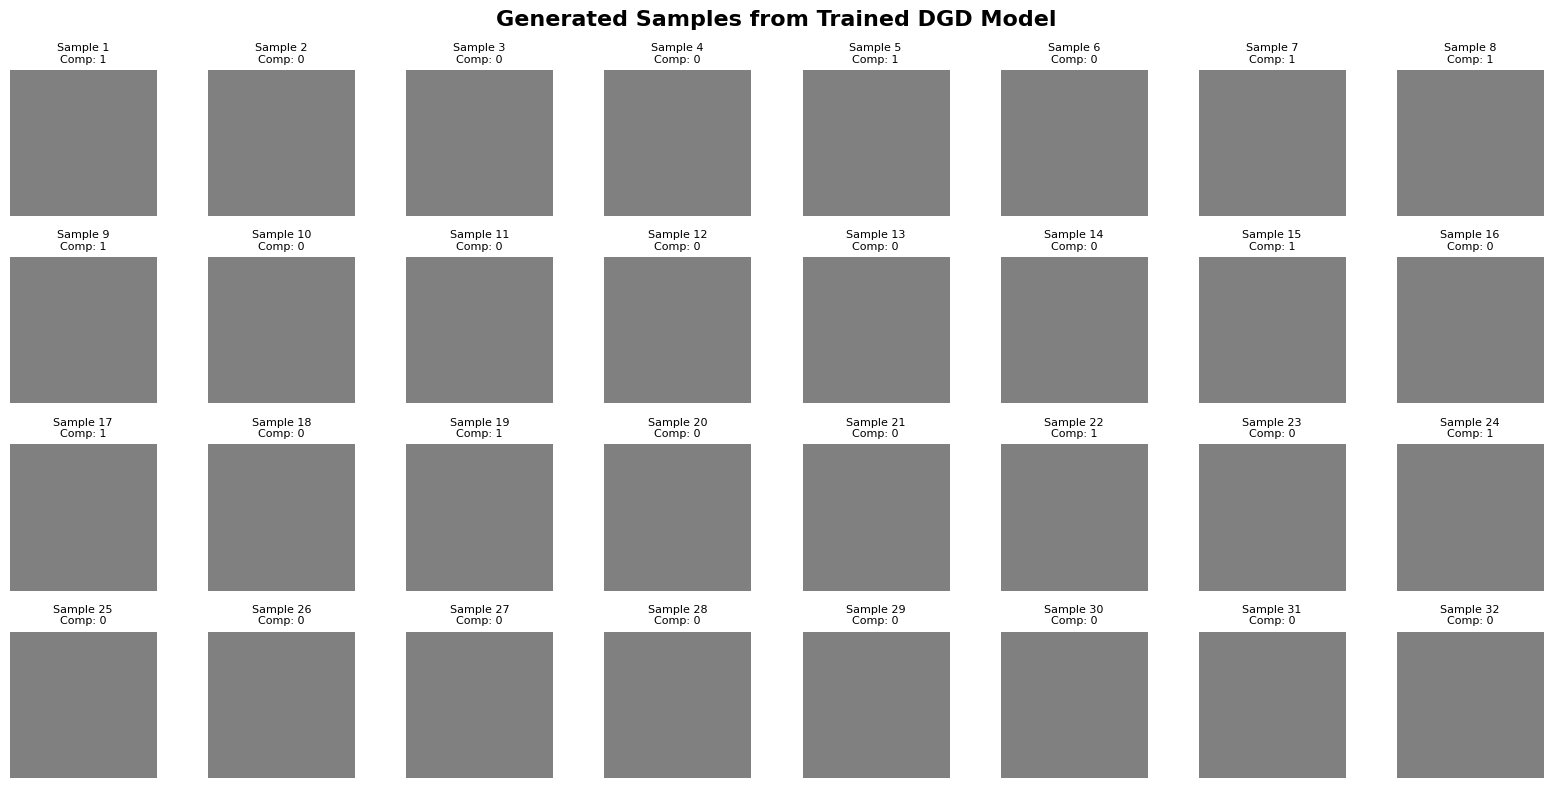


🎯 Generating samples from individual GMM components...


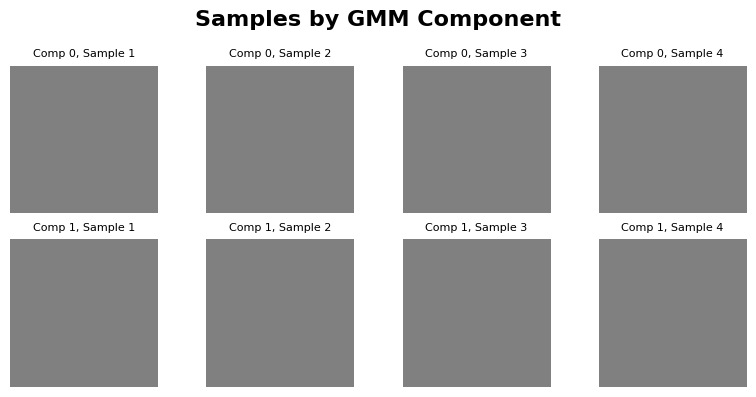


🌈 Demonstrating latent space interpolation...


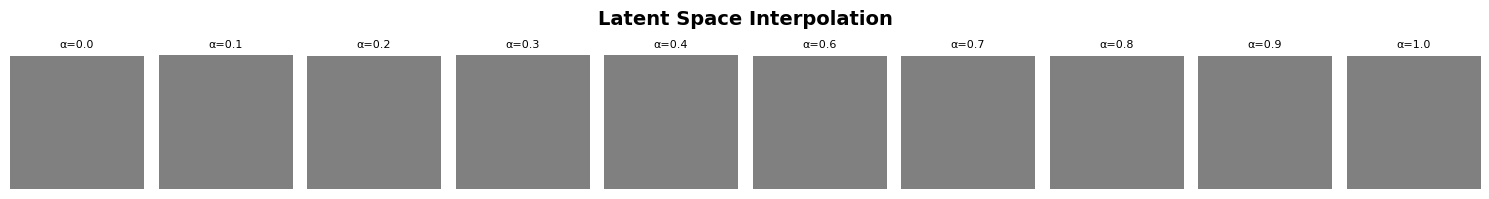


🎲 Comparing GMM sampling vs random sampling...


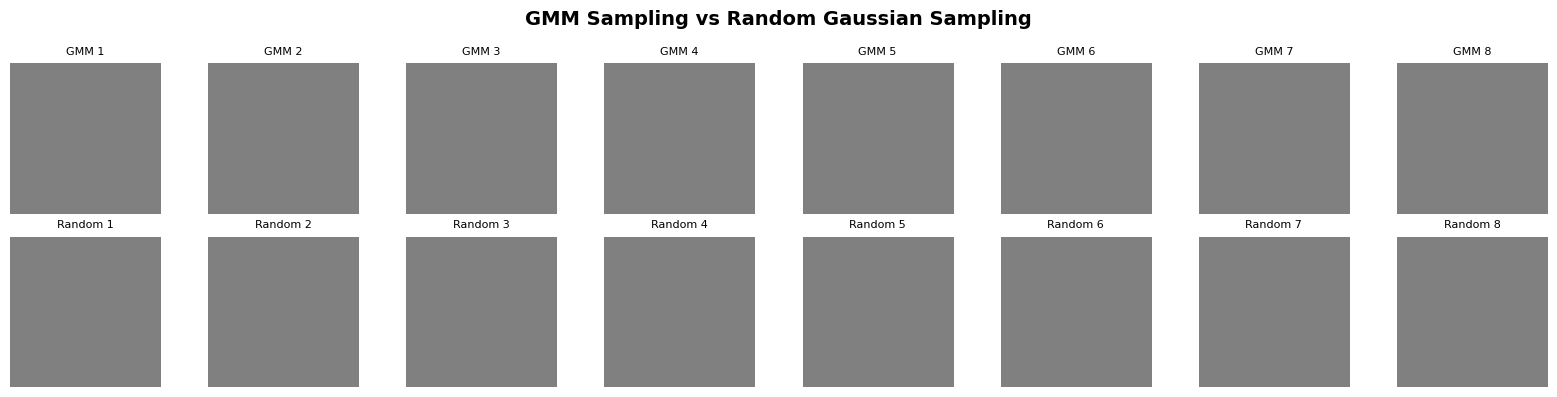

✅ Sample generation completed!
✓ GMM sampling produces more structured samples
✓ Random sampling may produce less realistic samples
✓ Interpolation shows smooth transitions in latent space


In [24]:
# Generate samples from the trained model
print("🎨 Generating samples from trained DGD model...")

if gmm.converged_:
    with torch.no_grad():
        # 1. Sample from GMM
        n_samples = 32
        z_samples, component_labels = gmm.sample(n_samples)
        
        # Generate images from samples
        generated_images = model.decoder(z_samples)
        
        print(f"✓ Generated {n_samples} samples from GMM")
        print(f"✓ Sample shape: {generated_images.shape}")
        print(f"✓ Component distribution: {np.bincount(component_labels.cpu().numpy())}")
        
        # Visualize generated samples
        fig, axes = plt.subplots(4, 8, figsize=(16, 8))
        fig.suptitle('Generated Samples from Trained DGD Model', fontsize=16, fontweight='bold')
        
        generated_images_cpu = generated_images.cpu()
        component_labels_cpu = component_labels.cpu()
        
        for i in range(min(32, n_samples)):
            row = i // 8
            col = i % 8
            
            img = generated_images_cpu[i].squeeze()
            img = torch.clamp((img + 1) / 2, 0, 1)  # Denormalize and clamp
            component = component_labels_cpu[i].item()
            
            axes[row, col].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[row, col].set_title(f'Sample {i+1}\nComp: {component}', fontsize=8)
            axes[row, col].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 2. Sample from each GMM component separately
        print("\n🎯 Generating samples from individual GMM components...")
        
        def sample_from_component(gmm, n_samples, component_idx):
            """Sample n_samples from a specific GMM component."""
            # Get the mean and covariance for the specific component
            mean = gmm.means_[component_idx]
            
            # Handle different covariance types
            if gmm.covariance_type == 'full':
                cov = gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'diag':
                cov = torch.diag_embed(gmm.covariances_[component_idx])
            elif gmm.covariance_type == 'spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_[component_idx]
            elif gmm.covariance_type == 'tied_full':
                cov = gmm.covariances_
            elif gmm.covariance_type == 'tied_diag':
                cov = torch.diag_embed(gmm.covariances_)
            elif gmm.covariance_type == 'tied_spherical':
                cov = torch.eye(gmm.n_features, device=gmm.device) * gmm.covariances_
            else:
                raise ValueError(f"Unsupported covariance type: {gmm.covariance_type}")
            
            # Sample from the multivariate normal distribution
            dist = torch.distributions.MultivariateNormal(mean, cov)
            samples = dist.sample((n_samples,))
            return samples
        
        # Generate samples from each component
        n_per_component = 4
        fig, axes = plt.subplots(gmm.n_components, n_per_component, figsize=(n_per_component*2, gmm.n_components*2))
        fig.suptitle('Samples by GMM Component', fontsize=16, fontweight='bold')
        
        for comp in range(gmm.n_components):
            # Sample from specific component
            z_comp = sample_from_component(gmm, n_per_component, comp)
            imgs_comp = model.decoder(z_comp)
            
            for j in range(n_per_component):
                img = imgs_comp[j].cpu().squeeze()
                img = torch.clamp((img + 1) / 2, 0, 1)
                
                if gmm.n_components == 1:
                    axes[j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[j].axis('off')
                else:
                    axes[comp, j].imshow(img, cmap='gray', vmin=0, vmax=1)
                    axes[comp, j].set_title(f'Comp {comp}, Sample {j+1}', fontsize=8)
                    axes[comp, j].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 3. Latent space interpolation
        print("\n🌈 Demonstrating latent space interpolation...")
        
        # Get two random samples from the latent space
        z1, _ = gmm.sample(1)
        z2, _ = gmm.sample(1)
        
        # Create interpolation
        n_steps = 10
        alphas = torch.linspace(0, 1, n_steps).to(device)
        
        interpolated_images = []
        for alpha in alphas:
            z_interp = (1 - alpha) * z1 + alpha * z2
            img_interp = model.decoder(z_interp)
            interpolated_images.append(img_interp)
        
        # Visualize interpolation
        fig, axes = plt.subplots(1, n_steps, figsize=(n_steps*1.5, 2))
        fig.suptitle('Latent Space Interpolation', fontsize=14, fontweight='bold')
        
        for i, img in enumerate(interpolated_images):
            img_cpu = img.cpu().squeeze()
            img_cpu = torch.clamp((img_cpu + 1) / 2, 0, 1)
            
            axes[i].imshow(img_cpu, cmap='gray', vmin=0, vmax=1)
            axes[i].set_title(f'α={alphas[i]:.1f}', fontsize=8)
            axes[i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        # 4. Random sampling comparison
        print("\n🎲 Comparing GMM sampling vs random sampling...")
        
        # GMM samples
        z_gmm, _ = gmm.sample(8)
        imgs_gmm = model.decoder(z_gmm)
        
        # Random Gaussian samples
        z_random = torch.randn(8, config.model.representation.n_features).to(device)
        imgs_random = model.decoder(z_random)
        
        # Visualize comparison
        fig, axes = plt.subplots(2, 8, figsize=(16, 4))
        fig.suptitle('GMM Sampling vs Random Gaussian Sampling', fontsize=14, fontweight='bold')
        
        for i in range(8):
            # GMM samples
            img = imgs_gmm[i].cpu().squeeze()
            img = torch.clamp((img + 1) / 2, 0, 1)
            axes[0, i].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[0, i].set_title(f'GMM {i+1}', fontsize=8)
            axes[0, i].axis('off')
            
            # Random samples
            img = imgs_random[i].cpu().squeeze()
            img = torch.clamp((img + 1) / 2, 0, 1)
            axes[1, i].imshow(img, cmap='gray', vmin=0, vmax=1)
            axes[1, i].set_title(f'Random {i+1}', fontsize=8)
            axes[1, i].axis('off')
        
        plt.tight_layout()
        plt.show()
        
        print("✅ Sample generation completed!")
        print(f"✓ GMM sampling produces more structured samples")
        print(f"✓ Random sampling may produce less realistic samples")
        print(f"✓ Interpolation shows smooth transitions in latent space")
        
else:
    print("⚠️ GMM did not converge - cannot generate meaningful samples")
    print("💡 Try training for more epochs or adjusting GMM parameters")

## 10. Save and Export Model

Finally, let's save the trained model components and demonstrate how to load them for future use.

💾 Saving trained DGD model components...
Model save directory: /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo
✓ Saved PyTorch model state dictionaries
✓ Saved GMM model
✓ Saved configuration
✓ Saved PyTorch model state dictionaries
✓ Saved GMM model
✓ Saved configuration
✓ Saved training results
✓ Saved training results
✓ Saved model metadata
\n📁 Saved files (7 total):
  decoder.pth: 0.07 MB
  train_representation.pth: 0.05 MB
  test_representation.pth: 0.01 MB
  gmm.pkl: 0.00 MB
  config.yaml: 0.00 MB
  training_results.pth: 0.00 MB
  metadata.pth: 0.00 MB
\n============================================================
🔄 Demonstrating Model Loading...
Loading DGD model from /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo...
✓ Saved model metadata
\n📁 Saved files (7 total):
  decoder.pth: 0.07 MB
  train_representation.pth: 0.05 MB
  test_representation.pth: 0.01 MB
  gmm.pkl: 0.00 MB
  config.yaml: 0.00 MB
  training_results.pth: 0.00 MB
  metadata.pth: 0.00 MB
\n===============

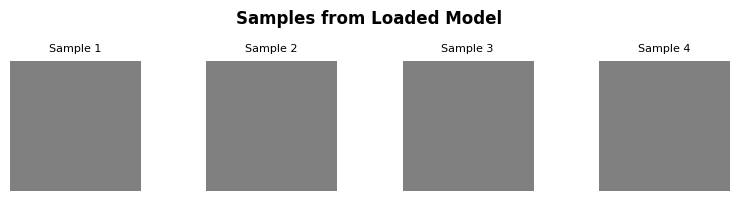

✓ Loaded model generates samples correctly!
\n============================================================
🎉 DGD Training Demo Complete!
\n📋 Summary:
✅ Trained DGD model for 10 epochs
✅ Final train loss: 535.794007
✅ Final test loss: 535.465797
✅ GMM fitted with 2 components
✅ Model saved to: /home/asp/Downloads/HeaDS/ImageDGD/models/dgd_demo
✅ Model loading verified
✅ Sample generation working
\n🚀 Next Steps:
• Try different configurations (latent dimensions, architectures)
• Experiment with different datasets
• Adjust GMM parameters for better clustering
• Use longer training for better convergence
• Explore different representation distributions
• Use ClearML for experiment tracking and comparison
\n📊 View results in ClearML: Task ID 5cb88899252a4a09974432d8bda03ee7
\n🎯 DGDTrainer Usage Demonstrated Successfully!
\n🎯 DGDTrainer Usage Demonstrated Successfully!


: 

In [ ]:
# Save the trained model components
print("💾 Saving trained DGD model components...")

# Create model save directory
model_dir = project_root / "models" / "dgd_demo"
model_dir.mkdir(parents=True, exist_ok=True)

print(f"Model save directory: {model_dir}")

# 1. Save model state dictionaries
torch.save(model.decoder.state_dict(), model_dir / "decoder.pth")
torch.save(rep_layer.state_dict(), model_dir / "train_representation.pth")
torch.save(test_rep_layer.state_dict(), model_dir / "test_representation.pth")

print("✓ Saved PyTorch model state dictionaries")

# 2. Save GMM model
import pickle
with open(model_dir / "gmm.pkl", "wb") as f:
    pickle.dump(gmm, f)

print("✓ Saved GMM model")

# 3. Save configuration
OmegaConf.save(config, model_dir / "config.yaml")

print("✓ Saved configuration")

# 4. Save training results
training_results = {
    'train_losses': train_losses,
    'test_losses': test_losses,
    'recon_train_losses': trainer.recon_train_losses,
    'recon_test_losses': trainer.recon_test_losses,
    'gmm_train_losses': trainer.gmm_train_losses,
    'gmm_test_losses': trainer.gmm_test_losses,
    'epoch_times': trainer.epoch_times,
    'final_train_loss': results['final_train_loss'],
    'final_test_loss': results['final_test_loss'],
    'total_time': results['total_time']
}

torch.save(training_results, model_dir / "training_results.pth")

print("✓ Saved training results")

# 5. Save model metadata
metadata = {
    'model_type': 'DGD',
    'dataset': config.data.dataset,
    'epochs_trained': len(train_losses),
    'latent_dim': config.model.representation.n_features,
    'decoder_params': sum(p.numel() for p in model.decoder.parameters()),
    'rep_params': sum(p.numel() for p in rep_layer.parameters()),
    'gmm_components': gmm.n_components,
    'gmm_converged': gmm.converged_,
    'training_date': time.strftime('%Y-%m-%d %H:%M:%S'),
    'device_used': str(device),
    'pytorch_version': torch.__version__
}

torch.save(metadata, model_dir / "metadata.pth")

print("✓ Saved model metadata")

# List all saved files
saved_files = list(model_dir.glob("*"))
print(f"\\n📁 Saved files ({len(saved_files)} total):")
for file in saved_files:
    size_mb = file.stat().st_size / (1024 * 1024)
    print(f"  {file.name}: {size_mb:.2f} MB")

print("\\n" + "="*60)
print("🔄 Demonstrating Model Loading...")

# Demonstrate loading the saved model
def load_dgd_model(model_dir, device):
    """Load a saved DGD model from directory."""
    print(f"Loading DGD model from {model_dir}...")
    
    # Load configuration
    config_loaded = OmegaConf.load(model_dir / "config.yaml")
    
    # Load metadata
    metadata = torch.load(model_dir / "metadata.pth", map_location=device)
    
    # Recreate decoder
    decoder_loaded = ConvDecoder(
        latent_dim=config_loaded.model.representation.n_features,
        hidden_dims=config_loaded.model.decoder.hidden_dims,
        output_channels=config_loaded.model.decoder.output_channels,
        output_size=config_loaded.model.decoder.output_size,
        use_batch_norm=config_loaded.model.decoder.use_batch_norm,
        activation=config_loaded.model.decoder.activation,
        final_activation=config_loaded.model.decoder.final_activation,
        dropout_rate=config_loaded.model.decoder.dropout_rate,
        init_size=config_loaded.model.decoder.init_size
    ).to(device)
    
    # Load decoder weights
    decoder_loaded.load_state_dict(torch.load(model_dir / "decoder.pth", map_location=device))
    
    # Load GMM
    with open(model_dir / "gmm.pkl", "rb") as f:
        gmm_loaded = pickle.load(f)
    
    # Recreate representation layers (for new data)
    rep_loaded = RepresentationLayer(
        dim=config_loaded.model.representation.n_features,
        n_samples=1000,  # Can be changed for new datasets
        dist=config_loaded.model.representation.distribution,
        dist_params={'radius': config_loaded.model.representation.radius} if hasattr(config_loaded.model.representation, 'radius') else {},
        device=device
    )
    
    # Create DGD model
    model_loaded = DGD(decoder_loaded, rep_loaded, gmm_loaded)
    
    print("✓ Model loaded successfully!")
    return model_loaded, config_loaded, metadata

# Load the model
loaded_model, loaded_config, loaded_metadata = load_dgd_model(model_dir, device)

print("✅ Model loading demonstration completed!")
print(f"✓ Loaded model trained for {loaded_metadata['epochs_trained']} epochs")
print(f"✓ Model parameters: {loaded_metadata['decoder_params']:,}")
print(f"✓ GMM converged: {loaded_metadata['gmm_converged']}")
print(f"✓ Training date: {loaded_metadata['training_date']}")

# Test the loaded model with a sample
print("\\n🧪 Testing loaded model...")
with torch.no_grad():
    # Sample from loaded GMM
    z_test_load, _ = loaded_model.gmm.sample(4)
    img_test_load = loaded_model.decoder(z_test_load)
    
    # Visualize
    fig, axes = plt.subplots(1, 4, figsize=(8, 2))
    fig.suptitle('Samples from Loaded Model', fontsize=12, fontweight='bold')
    
    for i in range(4):
        img = img_test_load[i].cpu().squeeze()
        img = torch.clamp((img + 1) / 2, 0, 1)
        axes[i].imshow(img, cmap='gray', vmin=0, vmax=1)
        axes[i].set_title(f'Sample {i+1}', fontsize=8)
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

print("✓ Loaded model generates samples correctly!")

# Final summary
print("\\n" + "="*60)
print("🎉 DGD Training Demo Complete!")
print("="*60)
print("\\n📋 Summary:")
print(f"✅ Trained DGD model for {len(train_losses)} epochs")
print(f"✅ Final train loss: {results['final_train_loss']:.6f}")
print(f"✅ Final test loss: {results['final_test_loss']:.6f}")
print(f"✅ GMM fitted with {gmm.n_components} components")
print(f"✅ Model saved to: {model_dir}")
print(f"✅ Model loading verified")
print(f"✅ Sample generation working")

print("\\n🚀 Next Steps:")
print("• Try different configurations (latent dimensions, architectures)")
print("• Experiment with different datasets")
print("• Adjust GMM parameters for better clustering")
print("• Use longer training for better convergence")
print("• Explore different representation distributions")
print("• Use ClearML for experiment tracking and comparison")

if task:
    print(f"\\n📊 View results in ClearML: Task ID {task.id}")
    # Mark task as completed
    task.mark_completed()

print("\\n🎯 DGDTrainer Usage Demonstrated Successfully!")